# Anomalia bouguer para a costa brasileira

## Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import verde as vd
import pyproj
import boule as bl
import harmonica as hm

In [2]:
notebook_name = '1. Brazilian_coast_bouguer_anomaly'

### Carregando os dados

In [3]:
fname = '../../data_set/gravity/gravity_01deg_Brazil_Coast_EIGEN-6C4.gdf'

In [4]:
data = hm.load_icgem_gdf(fname)

In [5]:
fname = '../../data_set/gravity/geoid_01deg_Brazil_Coast_EIGEN-6C4.gdf'

In [6]:
geoide = hm.load_icgem_gdf(fname)

In [7]:
data['geoid'] = geoide.geoid

In [8]:
fname = '../../data_set/gravity/topograhy_Brazil_Coast_etopo1.gdf'

In [9]:
topografia = hm.load_icgem_gdf(fname) 

In [10]:
data['topography'] = topografia.topography_shm

### Informações sobre a região e os dados

In [11]:
region = (-50, -30,-35, -15)

### Cálculo da gravidade normal

In [12]:
elipsoide = bl.WGS84

In [13]:
data['gamma'] = elipsoide.normal_gravity(data.latitude,data.h_over_geoid)

### Cálculo do distúrbio

In [14]:
data['disturbance'] = data.gravity_earth - data.gamma

### Cálculo da anomalia bouguer 

In [15]:
data['h_over_ell'] = data.geoid + data.topography
bouguer = hm.bouguer_correction(data.h_over_ell)
data['disturbance_bouguer'] = data.disturbance - bouguer

## Campo de gravidade, gravidade normal e distúrbio

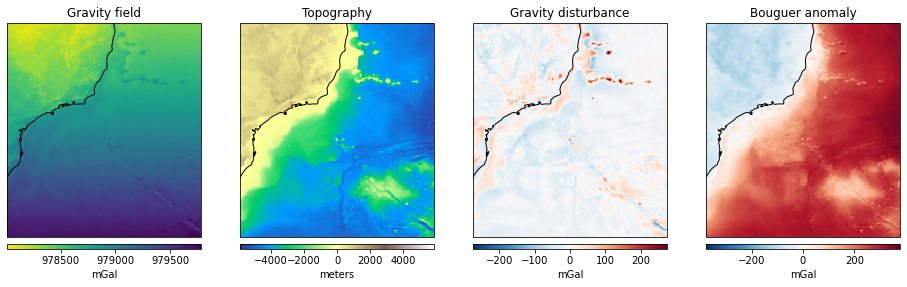

In [16]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(16, 12), subplot_kw=dict(projection=ccrs.Mercator()))

pg = data.gravity_earth.plot.pcolormesh(ax=ax1, cmap="viridis_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pg, ax=ax1, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax1.coastlines()
ax1.set_title("Gravity field")
ax1.set_extent(region,crs=ccrs.PlateCarree())

pn = data.h_over_ell.plot.pcolormesh(ax=ax2, cmap="terrain", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pn, ax=ax2, orientation="horizontal", pad=0.01, aspect=40, label="meters")
ax2.coastlines()
ax2.set_title("Topography")
ax2.set_extent(region,crs=ccrs.PlateCarree())

pd = data.disturbance.plot.pcolormesh(ax=ax3, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pd, ax=ax3, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax3.coastlines()
ax3.set_title("Gravity disturbance")
ax3.set_extent(region,crs=ccrs.PlateCarree())

pb = data.disturbance_bouguer.plot.pcolormesh(ax=ax4, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pb, ax=ax4, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax4.coastlines()
ax4.set_title("Bouguer anomaly")
ax4.set_extent(region,crs=ccrs.PlateCarree())

file_name = 'images/gravity_Brazil_Coast'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

## Visualização dos dados em um perfil

### Definindo as coordenadas em um grid regular

In [17]:
spacing = 0.1

In [18]:
longitude = np.arange(region[0],region[1]+spacing,step=spacing)
latitude = np.arange(region[2],region[3]+spacing,step=spacing)

In [19]:
long,lat = np.meshgrid(longitude,latitude)

In [20]:
full_coordinates = (long,lat)

### Decimando os dados de distúrbio

In [21]:
spacing = 1/ 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, disturbance = reducer.filter(
    (long,lat), data.disturbance.values)

In [22]:
projection = pyproj.Proj(proj="merc", lat_ts=coordinates[1].mean())
proj_coords = projection(*coordinates)

### Interpolação dos dados sobre os perfis

In [23]:
spline = vd.ScipyGridder(method='cubic')

In [24]:
start = (-45,-18)
end = (-40,-30)

#### Perfil do distúrbio

In [25]:
interpolate_dist = spline.fit(proj_coords,disturbance)

In [26]:
profile_dist = interpolate_dist.profile(
    point1=start,
    point2=end, 
    size=400, 
    dims=("latitude","longitude"),
    data_names=["disturbance"],
    projection=projection,)

In [27]:
profile_dist

,latitude,longitude,distance,disturbance
0,-18.000000,-45.000000,0.000000e+00,3.013061
1,-18.031403,-44.987469,3.546666e+03,3.641667
2,-18.062800,-44.974937,7.093331e+03,4.667964
3,-18.094192,-44.962406,1.064000e+04,5.705078
4,-18.125578,-44.949875,1.418666e+04,6.661903
...,...,...,...,...
395,-29.885660,-40.050125,1.400933e+06,-10.770006
396,-29.914258,-40.037594,1.404480e+06,-10.452826
397,-29.942847,-40.025063,1.408026e+06,-10.977141
398,-29.971427,-40.012531,1.411573e+06,-12.253454


### Decimando os dados de topografia

In [28]:
spacing = 1/ 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, topography = reducer.filter(
    (long,lat), data.h_over_ell.values)

In [29]:
interpolate_topo = spline.fit(proj_coords,topography)

#### Perfil dos dados de topografia

In [30]:
profile_topo = interpolate_topo.profile(
    point1=start,
    point2=end, 
    size=400, 
    dims=("latitude","longitude"),
    data_names=["topography"],
    projection=projection,)

In [31]:
profile_topo

,latitude,longitude,distance,topography
0,-18.000000,-45.000000,0.000000e+00,685.474939
1,-18.031403,-44.987469,3.546666e+03,694.635015
2,-18.062800,-44.974937,7.093331e+03,710.259171
3,-18.094192,-44.962406,1.064000e+04,729.887897
4,-18.125578,-44.949875,1.418666e+04,760.292410
...,...,...,...,...
395,-29.885660,-40.050125,1.400933e+06,-3145.170654
396,-29.914258,-40.037594,1.404480e+06,-3115.147949
397,-29.942847,-40.025063,1.408026e+06,-3132.314341
398,-29.971427,-40.012531,1.411573e+06,-3171.316384


### Decimando os dados de anomalia bouguer

In [32]:
spacing = 1/ 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)
coordinates, bouguer_topo = reducer.filter(
    (long,lat), data.disturbance_bouguer.values)

In [33]:
interpolate_bouguer = spline.fit(proj_coords,bouguer_topo)

In [34]:
profile_bouguer = interpolate_bouguer.profile(
    point1=start,
    point2=end, 
    size=400, 
    dims=("latitude","longitude"),
    data_names=["bouguer"],
    projection=projection,)

In [35]:
profile_bouguer

,latitude,longitude,distance,bouguer
0,-18.000000,-45.000000,0.000000e+00,-73.723766
1,-18.031403,-44.987469,3.546666e+03,-74.120583
2,-18.062800,-44.974937,7.093331e+03,-74.843383
3,-18.094192,-44.962406,1.064000e+04,-76.003680
4,-18.125578,-44.949875,1.418666e+04,-78.450544
...,...,...,...,...
395,-29.885660,-40.050125,1.400933e+06,204.177688
396,-29.914258,-40.037594,1.404480e+06,202.443079
397,-29.942847,-40.025063,1.408026e+06,203.091944
398,-29.971427,-40.012531,1.411573e+06,204.481100


## Visualização dos perfis

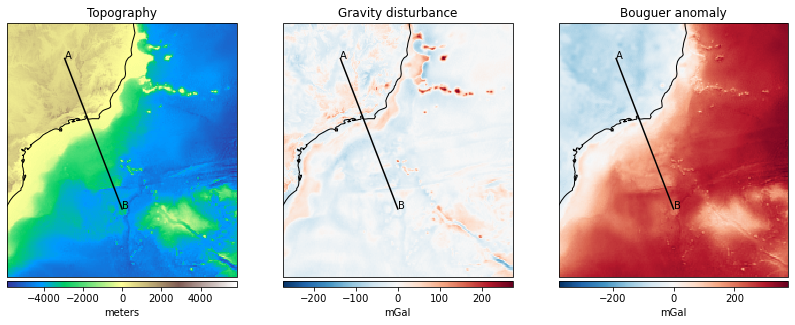

In [36]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14, 8), subplot_kw=dict(projection=ccrs.Mercator()))

pn = data.h_over_ell.plot.pcolormesh(ax=ax1, cmap="terrain", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pn, ax=ax1, orientation="horizontal", pad=0.01, aspect=40, label="meters")
ax1.plot(profile_topo.longitude, profile_topo.latitude, "-k", transform=ccrs.PlateCarree())
ax1.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax1.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title("Topography")
ax1.set_extent(region,crs=ccrs.PlateCarree())

pd = data.disturbance.plot.pcolormesh(ax=ax2, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pd, ax=ax2, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax2.plot(profile_dist.longitude, profile_dist.latitude, "-k", transform=ccrs.PlateCarree())
ax2.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax2.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title("Gravity disturbance")
ax2.set_extent(region,crs=ccrs.PlateCarree())

pb = data.disturbance_bouguer.plot.pcolormesh(ax=ax3, cmap="RdBu_r", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pb, ax=ax3, orientation="horizontal", pad=0.01, aspect=40, label="mGal")
ax3.plot(profile_bouguer.longitude, profile_bouguer.latitude, "-k", transform=ccrs.PlateCarree())
ax3.text(start[0], start[1], "A", transform=ccrs.PlateCarree())
ax3.text(end[0], end[1], "B", transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title("Bouguer anomaly")
ax3.set_extent(region,crs=ccrs.PlateCarree())

file_name = 'images/profile_Brazil_Coast'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

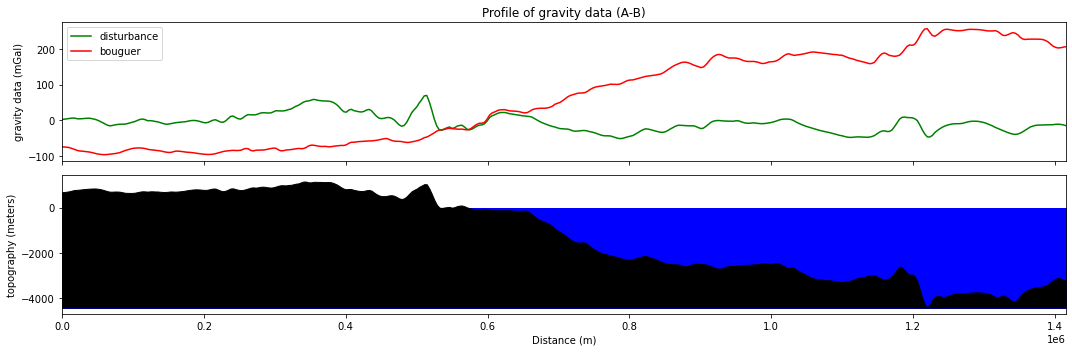

In [37]:
fig,(ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(15, 5))

### Disturbio e anomalia bouguer (com a topografia)
ax1.set_title("Profile of gravity data (A-B)")
ax1.plot(profile_dist.distance, profile_dist.disturbance, "-g",label='disturbance')
ax1.plot(profile_bouguer.distance, profile_bouguer.bouguer, "-r",label='bouguer')
ax1.set_ylabel("gravity data (mGal)")
ax1.set_xlim(profile_dist.distance.min(), profile_dist.distance.max())
ax1.legend()

### Topografia e o nível do mar
ax2.fill_between(profile_topo.distance,0.,min(profile_topo.topography),color='blue')
ax2.fill_between(profile_topo.distance,profile_topo.topography,min(profile_topo.topography),color='black')
ax2.set_ylabel("topography (meters)")
ax2.set_xlim(profile_topo.distance.min(), profile_topo.distance.max())
ax2.set_xlabel("Distance (m)")

file_name = 'images/disturbance_bouguer_comparison_Brazil_Coast'
plt.savefig(file_name+'.png',dpi=300)

plt.tight_layout()
plt.show()

## Calculando o effeito da Moho pela topografia equivalente

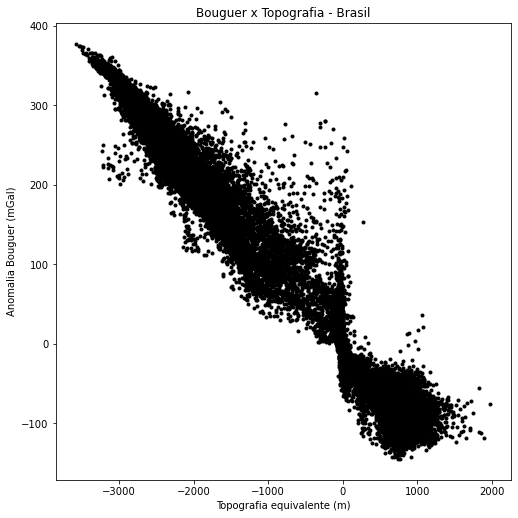

In [38]:
heq = data.h_over_ell.values
heq[heq < 0] *= (2670 - 1040)/2670
plt.figure(figsize=(7, 7))
plt.title('Bouguer x Topografia - Brasil')
plt.plot(heq, data.disturbance_bouguer.values, '.k')
plt.xlabel('Topografia equivalente (m)')
plt.ylabel('Anomalia Bouguer (mGal)')
plt.tight_layout(pad=0)

In [39]:
heq = data.h_over_ell.values.ravel()
heq[heq < 0] *= (2670 - 1040)/2670
A = np.ones((heq.size, 2))
A[:, 0] = heq
p = np.linalg.solve(A.T.dot(A), A.T.dot(data.disturbance_bouguer.values.ravel()))
efeito_moho = A.dot(p)

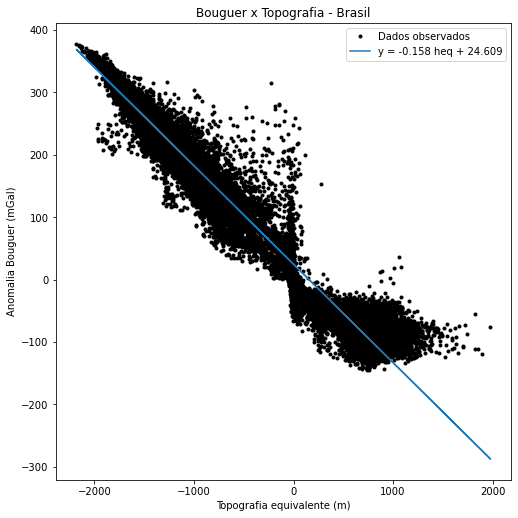

In [40]:
plt.figure(figsize=(7, 7))
plt.title('Bouguer x Topografia - Brasil')
plt.plot(heq, data.disturbance_bouguer.values.ravel(),'.k', label='Dados observados')
plt.plot(heq, efeito_moho, '-', label='y = {:.3f} heq + {:.3f}'.format(*p))
plt.legend(loc='upper right')
plt.xlabel('Topografia equivalente (m)')
plt.ylabel('Anomalia Bouguer (mGal)')
plt.tight_layout(pad=0)

## Visualização das anomalias de gravidade na costa brasileira sem o efeito da Moho

In [41]:
data['residuals'] = data.disturbance_bouguer - np.reshape(efeito_moho,(201,201))

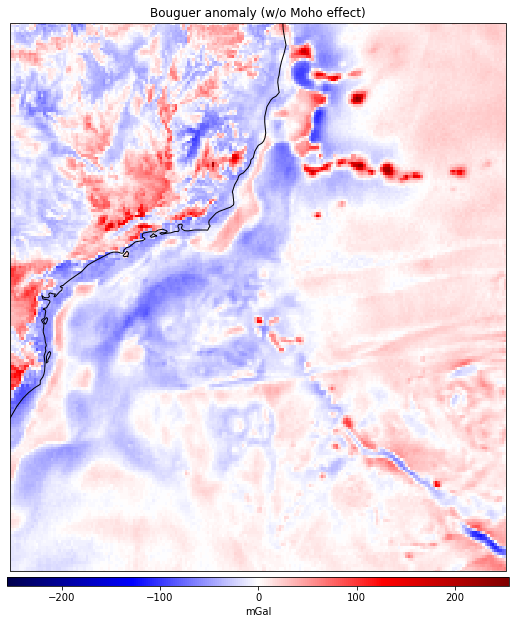

In [42]:
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.Mercator())
pb = data.residuals.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, transform=ccrs.PlateCarree())
plt.colorbar(pb, ax=ax, orientation="horizontal", pad=0.01, aspect=60,shrink=.75, label="mGal")
ax.coastlines()
ax.set_title("Bouguer anomaly (w/o Moho effect)")
ax.set_extent(region,crs=ccrs.PlateCarree())

file_name = 'images/bouguer_anomaly_without_Moho'
plt.savefig(file_name+'.png',dpi=300)

plt.show()